In [3]:
import numpy
import numpy as np
import src.models.model as NET_FCN  # The net Class
import torch
import torch.nn as nn
import torch.nn.functional as F
import src.models.loss_functions
import src.data.load_data as ReaderData
import src.data.make_dataset as MakeDataset
from matplotlib import pyplot as plt
from src.utils import metrics
import src.models.loss_functions as LossFunctions



In [123]:
#TestFolder = r"data/interim/TranProteus8/Testing/LiquidContent" # input folder
TestFolder = r"data/interim/TranProteus/Testing/LiquidContent" # input folder
TrainFolder = r"data/interim/TranProteus/Training/LiquidContent" # input folder
#TestFolder = r"data/interim/LabPics Chemistry/Test" # input folder
#model_path =  r"models/40__29032023-0231.torch" # Trained model path
model_path =  r"models/55__03042023-2211.torch" # Trained model path

OutputStatisticsFile = "Statistics.txt"
MaxSize=1000# max image dimension
UseChamfer = False # Evaluate chamfer distance (this takes lots of time)
#SetNormalizationUsing="ContentXYZ"
SetNormalizationUsing="VesselXYZ" # Normalize prediction scale to GT scale by matching the vessel scale
UseGPU = True # Use GPU for inference
batch_size = 1 # Batch size

In [124]:
MaskClasses = {}
DepthList = [
        "EmptyVessel_Depth",
        "ContentDepth",
        "VesselOpening_Depth",
    ]  # List of depth maps to predict
MaskList = [
        "VesselMask",
        "ContentMaskClean",
        "VesselOpeningMask",
    ]  # List of segmentation Masks to predict
depth2Mask = {
        "EmptyVessel_Depth": "VesselMask",
        "ContentDepth": "ContentMaskClean",
        "VesselOpening_Depth": "VesselOpeningMask",
    }
Statics={""}

In [125]:
model = NET_FCN.Net(MaskList=MaskList, DepthList=DepthList)
# Load model weights depending on GPU usage
if UseGPU == True:
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

Net(
  (Encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [130]:
Readers = MakeDataset.create_reader_Test(batch_size, TestFolder)
Readers_train = MakeDataset.create_reader_Test(batch_size, TrainFolder)

Folder used: Liquid1
Creating annotation list for reader. This might take a while.
Done making file list.
Total number of samples = 1296
Folder used: Liquid1
Creating annotation list for reader. This might take a while.
Done making file list.
Total number of samples = 5908


In [116]:
#-------------------------------Create Evaluation statistics dictionary for depth--------------------------------------------------------------------
# https://github.com/wl-zhao/VPD

EvalTypes=["d1", "d2", "d3", "abs_rel", "sq_rel", "RMSE", "RMSE_log", "log10", "silog"] # List of evaluation metrics

StatDepth={} # Sum All statistics across
for nm in DepthList:
    StatDepth[nm]={}
    for et in EvalTypes:
        StatDepth[nm][et]=0

In [117]:
StatDepth

{'EmptyVessel_Depth': {'d1': 0,
  'd2': 0,
  'd3': 0,
  'abs_rel': 0,
  'sq_rel': 0,
  'RMSE': 0,
  'RMSE_log': 0,
  'log10': 0,
  'silog': 0},
 'ContentDepth': {'d1': 0,
  'd2': 0,
  'd3': 0,
  'abs_rel': 0,
  'sq_rel': 0,
  'RMSE': 0,
  'RMSE_log': 0,
  'log10': 0,
  'silog': 0},
 'VesselOpening_Depth': {'d1': 0,
  'd2': 0,
  'd3': 0,
  'abs_rel': 0,
  'sq_rel': 0,
  'RMSE': 0,
  'RMSE_log': 0,
  'log10': 0,
  'silog': 0}}

In [131]:
Readers = Readers["Liquid1"]
Readers_train = Readers_train["Liquid1"]

In [122]:
while (Readers.epoch==0 and Readers.itr<3): # Test 100 example or one epoch
    GT = Readers.LoadSingle() # Load example

    print("------------------------------", Readers.itr, "------------------------------------------------")
    print("RUN PREDICTION")

    with torch.no_grad():
          PrdDepth, PrdProb, PrdMask = model.forward(Images=GT["VesselWithContentRGB"]) # Run net inference and get prediction

    NormConst=[] # Scale normalization constant

# ########################################## Predict Depth #######################################################################
    for nm in DepthList:
        print("Predicting ", nm)
        if nm in GT:
            ROI=GT['ROI'][0]

            # get segmentation mask
            Gmask = GT[depth2Mask[nm]][0] * ROI  # GT mask  limite to region of ineterstr (ROI)
            print(depth2Mask[nm])

            # get prediction of depth map
            Pdepth= nn.functional.interpolate(PrdDepth[nm], tuple((GT['ROI'].shape[1], GT['ROI'].shape[2])),mode='bilinear', align_corners=False)
            Pdepth=Pdepth[0][0].cpu().detach().numpy().astype(np.float32)
            Pdepth *= ROI  # Limit to the region of intersection
            # get only the region of segmentation mask
            Pdepth = Pdepth * Gmask
            #print("Pdepth.shape", Pdepth.shape)
            #print(Pdepth)
            
            # show image
            plt.figure()
            plt.imshow(Pdepth, interpolation='nearest')


            Gdepth=GT[nm][0]*ROI # GT depth  limite to region of ineterstr (ROI)
            # get only the region of segmentation mask
            Gdepth = Gdepth * Gmask
            #print("Gdepth.shape", Gdepth.shape)
            #print(Gdepth)
            scale_factor = Gdepth[Gdepth > 0].mean() / Pdepth[Pdepth > 0].mean()
            Pdepth *= scale_factor

            # show image
            plt.figure()
            plt.imshow(Gdepth, interpolation='nearest')

            # convert to torch tensor
            Pdepth = torch.from_numpy(Pdepth)
            Gdepth = torch.from_numpy(Gdepth)
            #Pdepth = torch.pow(2.718281, Pdepth)

            print("Mean Gdepth", Gdepth[Gdepth > 0].mean())
            #print("max Gdepth", Gdepth.max())
            print("Mean Pdepth", Pdepth[Pdepth > 0].mean())
            #Pdepth = np.pow(2.718281, Pdepth)
            #print("max Pdepth", Pdepth.max())

            print("PrdDepth max: ", Pdepth.max())
            #print("PrdDepth min: ", Pdepth.min())
            print("TGT max: ", Gdepth.max())
            # min of Gdepth except for 0
            print("TGT min: ", Gdepth[Gdepth > 0].min())
            # min of Pdepth except for 0
            print("PrdDepth min: ", Pdepth[Pdepth > 0].min())

            ROI = torch.autograd.Variable(
                        torch.from_numpy(GT[depth2Mask[nm]] * GT["ROI"])
                        .unsqueeze(1),
                        requires_grad=False,
                    )  # ROI to torch
            ROI[
                ROI < 0.9
            ] = 0  # Resize have led to some intirmidiate values ignore them
            ROI[
                ROI > 0.9
            ] = 1  # Resize have led to some intirmidiate values ignore them

            print("ROI.shape", ROI.shape)
            print("Pdepth.shape", Pdepth.shape)
            print("Gdepth.shape", Gdepth.shape)

            loss = LossFunctions.DepthLoss(Pdepth, Gdepth, ROI)
            print("Loss ", loss)

            # calculate metrics
            dic = metrics.eval_depth(Pdepth, Gdepth)
            print(dic)

In [10]:
print(Gdepth)

# print number of non zero elements
print("Number of non-zero elements in the array : ", np.count_nonzero(Gdepth))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Number of non-zero elements in the array :  893


In [11]:
(Gdepth != 0)*Gdepth

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [12]:
# Segmentation mask loss
ROI = torch.autograd.Variable(
    torch.from_numpy(GT["ROI"]).unsqueeze(1), requires_grad=False
)  # Region of interest in the image where loss is calulated
ROI = nn.functional.interpolate(
    ROI,
    tuple((PrdProb[MaskList[0]].shape[2], PrdProb[MaskList[0]].shape[3])),
    mode="bilinear",
    align_corners=False,
)  # Resize ROI to prediction size (prediction map is shrink version of the input image)

ROI shape:  torch.Size([1, 1, 225, 225])
TGT shape:  torch.Size([1, 1, 225, 225])
PrdDepth[nm] shape:  torch.Size([1, 1, 225, 225])
CatLoss[nm]  tensor(0.0018)
PrdDepth max:  tensor(1.2013)
PrdDepth min:  tensor(-0.0425)
TGT max:  tensor(6.4947)
TGT min:  tensor(-9.2103)
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
Number of non-zero elements in the array :  1790
{'abs_rel': 0.5923271179199219, 'sq_rel': 2.0944244861602783, 'rmse': 3.5352535247802734, 'rmse_log': 0.8981598615646362, 'log10': 0.3898679316043854, 'silog': 0.6354169845581055}
ROI shape:  torch.Size([1, 1, 225, 225])
TGT shape:  torch.Size([1, 1, 225, 225])
PrdDepth[nm] shape:  torch.Size([1, 1, 225, 225])
CatLoss[nm]  tensor(0.0022)
PrdDepth max:  tensor(3.6798)
PrdDepth min:  tensor(1.4098)
TGT max: 

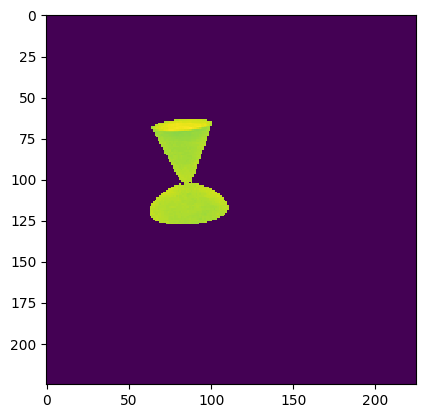

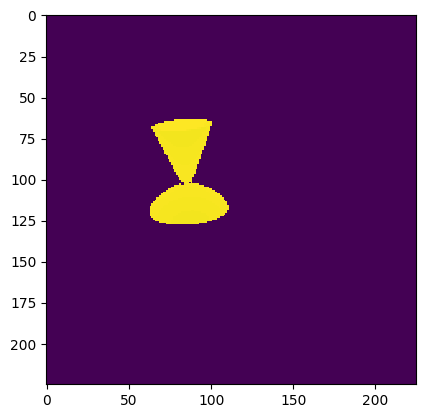

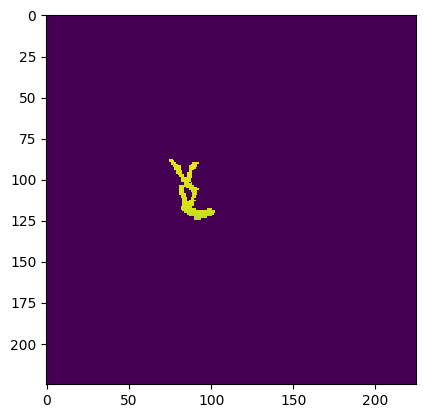

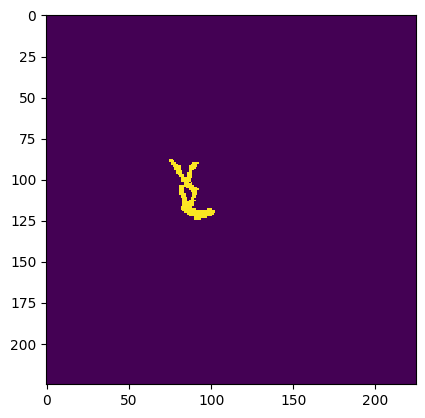

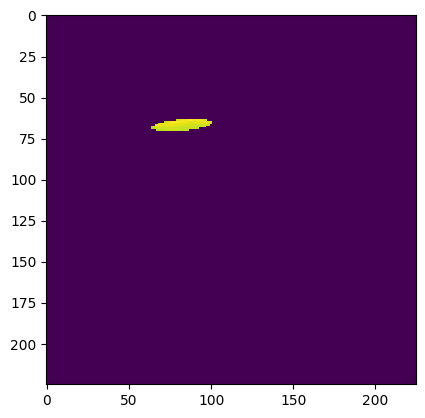

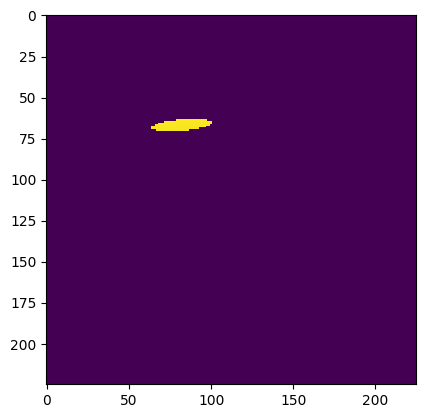

In [23]:
TGT = {}  # GT depth in torch format
CatLoss = {}    # Loss for each category
for nm in DepthList:
    # ROI Punish depth prediction only within the object mask, resize ROI to prediction size (prediction map is shrink version of the input image)
    ROI = torch.autograd.Variable(
        torch.from_numpy(GT[depth2Mask[nm]] * GT["ROI"])
        .unsqueeze(1),
        requires_grad=False,
    )  # ROI to torch
    ROI = nn.functional.interpolate(
        ROI,
        tuple(
            (PrdDepth[nm].shape[2], PrdDepth["EmptyVessel_Depth"].shape[3])
        ),
        mode="bilinear",
        align_corners=False,
    )  # ROI to output scale
    ROI[
        ROI < 0.9
    ] = 0  # Resize have led to some intirmidiate values ignore them
    ROI[
        ROI > 0.9
    ] = 1  # Resize have led to some intirmidiate values ignore them
    print("ROI shape: ", ROI.shape)

    TGT[nm] = torch.log(
        torch.from_numpy(GT[nm]).unsqueeze(1) + 0.0001
    )  # GT Depth log
    TGT[nm].requires_grad = False
    TGT[nm] = nn.functional.interpolate(
        TGT[nm],
        tuple((PrdDepth[nm].shape[2], PrdDepth[nm].shape[3])),
        mode="bilinear",
        align_corners=False,
    )  # convert to prediction size
    print("TGT shape: ", TGT[nm].shape)
    
    
    CatLoss[nm] = 5 * LossFunctions.DepthLoss(
        PrdDepth[nm], TGT[nm], ROI
    )  # Loss function

    print("PrdDepth[nm] shape: ", PrdDepth[nm].shape)
    print("CatLoss[nm] ", CatLoss[nm])
    print("PrdDepth max: ", PrdDepth[nm].max())
    print("PrdDepth min: ", PrdDepth[nm].min())
    print("TGT max: ", TGT[nm].max())
    print("TGT min: ", TGT[nm].min())

    #PrdDepth[nm] = torch.pow(2.718281, PrdDepth[nm])


    dic = metrics.eval_depth(PrdDepth[nm]*ROI, TGT[nm]*ROI)
    print(PrdDepth[nm]*ROI)
    # print non zero elements
    print("Number of non-zero elements in the array : ", np.count_nonzero(PrdDepth[nm]*ROI))
    print(dic)

    #convert TGT to np and show image
    # show image
    Pdepth = PrdDepth[nm]*ROI
    # convert Pdepth to numpy
    Pdepth = Pdepth.squeeze().cpu().detach().numpy().astype(np.float32)
    plt.figure()
    plt.imshow(Pdepth, interpolation='nearest')

    Gdepth = TGT[nm]*ROI
    # convert Gdepth to numpy
    Gdepth = Gdepth.squeeze().cpu().detach().numpy().astype(np.float32)
    plt.figure()
    plt.imshow(Gdepth, interpolation='nearest')



In [15]:
CatLoss

{'EmptyVessel_Depth': tensor(0.0028),
 'ContentDepth': tensor(0.0012),
 'VesselOpening_Depth': tensor(0.0021)}

In [15]:
dic

{'abs_rel': 0.40824592113494873,
 'sq_rel': 0.867553174495697,
 'rmse': 2.124751091003418,
 'rmse_log': 0.5249358415603638,
 'log10': 0.22789940237998962,
 'silog': 0.37131157517433167}

In [16]:
# get first element of the dictionary
first_key = list(dic.keys())[0]
first_key
# get the value of the first element
dic[first_key]


0.40824592113494873

In [132]:
'''
Problem to solve: scale ambiguity in depth prediction from a monocular image

See chapter "Scale invariant loss" in Transproteus paper

Idea: get scaling factor from training images and use its mean to scale the depth prediction

1. Get the scaling factor from the training images
2. Use the scaling factor to scale the depth prediction

Additional possible approach (maybe smart):
1. Take depth image with depth camera
2. Predict depth map from monocular image
3. Calculate scaling factor from depth image and depth map outside of masks
4. Use scaling factor to scale depth map inside of masks


Papers: "Monodepth: Single Image Depth Estimation from Unsupervised Adversarial Networks" by Godard et al. (2017). In this paper, the authors propose a self-supervised method for monocular depth estimation that incorporates a scale-invariant depth loss. This loss encourages the network to learn depth predictions that are consistent with the input image and do not depend on a particular scale.

"Learning the Depths of Moving People by Watching Frozen People" by Zhou et al. (2018). In this paper, the authors propose a method for monocular depth estimation that uses a combination of stereo supervision and temporal consistency. They introduce a scale factor as a learnable parameter that is optimized jointly with the network weights.

"Unsupervised Scale-consistent Depth and Ego-motion Learning from Monocular Video" by Yin et al. (2020). In this paper, the authors propose a self-supervised method for monocular depth and ego-motion estimation that explicitly models the scale factor as a latent variable. They use a deep generative model to infer the scale factor and the depth maps from the input image sequence.

'''

ScaleDepth={} # Sum All statistics across
for nm in DepthList:
    ScaleDepth[nm]={}

while (Readers_train.epoch==0 and Readers_train.itr<400): # Test 100 example or one epoch
    GT = Readers_train.LoadSingle() # Load example

    print("------------------------------", Readers_train.itr, "------------------------------------------------")
    #print("RUN PREDICTION")

    with torch.no_grad():
          PrdDepth, PrdProb, PrdMask = model.forward(Images=GT["VesselWithContentRGB"]) # Run net inference and get prediction

    NormConst=[] # Scale normalization constant

# ########################################## Predict Depth #######################################################################
    for nm in DepthList:
        #print("Predicting ", nm)
        if nm in GT:
            ROI=GT['ROI'][0]

            ROI = torch.autograd.Variable(
                        torch.from_numpy(GT[depth2Mask[nm]] * GT["ROI"])
                        .unsqueeze(1),
                        requires_grad=False,
                    )  # ROI to torch
            ROI[
                ROI < 0.9
            ] = 0  # Resize have led to some intirmidiate values ignore them
            ROI[
                ROI > 0.9
            ] = 1  # Resize have led to some intirmidiate values ignore them
            # get segmentation mask
            # ROI to numpy
            ROI = ROI.squeeze().cpu().detach().numpy().astype(np.float32)

            Gmask = GT[depth2Mask[nm]][0] * ROI  # GT mask  limite to region of ineterstr (ROI)

            # get prediction of depth map
            Pdepth= nn.functional.interpolate(PrdDepth[nm], tuple((GT['ROI'].shape[1], GT['ROI'].shape[2])),mode='bilinear', align_corners=False)
            Pdepth=Pdepth[0][0].cpu().detach().numpy().astype(np.float32)
            Pdepth *= ROI  # Limit to the region of intersection
            # get only the region of segmentation mask
            Pdepth = Pdepth * Gmask

            # Convert from log depth to depth
            Pdepth[Pdepth > 0] = np.power(2.718281, Pdepth[Pdepth > 0])

            Gdepth=GT[nm][0]*ROI # GT depth  limite to region of ineterstr (ROI)
            # get only the region of segmentation mask
            Gdepth = Gdepth * Gmask
            #print("Gdepth.shape", Gdepth.shape)
            #print(Gdepth)
            if (len(Pdepth[Pdepth > 0]) > 0 and len(Gdepth[Gdepth > 0]) > 0):
                # calculate scale factor
                scale_factor = max(Gdepth[Gdepth > 0].mean(), 1) / max(Pdepth[Pdepth > 0].mean(), 1) # called K in paper
                # add scale factor to the dictionary
                ScaleDepth[nm][Readers_train.itr] = scale_factor


# get means of the dictionary
for nm in DepthList:
    ScaleDepth[nm] = np.mean(list(ScaleDepth[nm].values()))
    print(nm, ScaleDepth[nm])

data/interim/TranProteus/Training/LiquidContent//1///VesselWithContent_Frame_120_RGB.jpg
------------------------------ 1 ------------------------------------------------
data/interim/TranProteus/Training/LiquidContent//1///VesselWithContent_Frame_150_RGB.jpg
------------------------------ 2 ------------------------------------------------
data/interim/TranProteus/Training/LiquidContent//1///VesselWithContent_Frame_60_RGB.jpg
------------------------------ 3 ------------------------------------------------
data/interim/TranProteus/Training/LiquidContent//1///VesselWithContent_Frame_90_RGB.jpg
------------------------------ 4 ------------------------------------------------
data/interim/TranProteus/Training/LiquidContent//10002///VesselWithContent_Frame_120_RGB.jpg
------------------------------ 5 ------------------------------------------------
data/interim/TranProteus/Training/LiquidContent//10002///VesselWithContent_Frame_150_RGB.jpg
------------------------------ 6 -----------------

In [73]:
ScaleDepth

{'EmptyVessel_Depth': 94.25635,
 'ContentDepth': 9.424899,
 'VesselOpening_Depth': 10.522072}

In [133]:
'''
Use calculated scaling factor to scale the depth prediction and evaluate results on test set

'''

EvalTypes=["abs_rel", "sq_rel", "rmse", "rmse_log", "log10", "silog"] # List of evaluation metrics

StatDepth={} # Sum All statistics across
for nm in DepthList:
    StatDepth[nm]={}
    for et in EvalTypes:
        StatDepth[nm][et]=0

# create an array of length DepthList to store the counts
count = np.zeros(len(DepthList))

while (Readers.epoch==0 and Readers.itr<5): # Test 100 example or one epoch
    GT = Readers.LoadSingle() # Load example

    print("------------------------------", Readers.itr, "------------------------------------------------")
    #print("RUN PREDICTION")

    with torch.no_grad():
          PrdDepth, PrdProb, PrdMask = model.forward(Images=GT["VesselWithContentRGB"]) # Run net inference and get prediction

    NormConst=[] # Scale normalization constant

# ########################################## Predict Depth #######################################################################
    i = 0
    for nm in DepthList:
        #print("Predicting ", nm)
        
        if nm in GT:
            ROI=GT['ROI'][0]

            # get segmentation mask
            Gmask = GT[depth2Mask[nm]][0] * ROI  # GT mask  limite to region of ineterstr (ROI)
            #print(depth2Mask[nm])

            # get prediction of depth map
            Pdepth= nn.functional.interpolate(PrdDepth[nm], tuple((GT['ROI'].shape[1], GT['ROI'].shape[2])),mode='bilinear', align_corners=False)
            Pdepth=Pdepth[0][0].cpu().detach().numpy().astype(np.float32)
            Pdepth *= ROI  # Limit to the region of intersection
            # get only the region of segmentation mask
            Pdepth = Pdepth * Gmask

            Gdepth=GT[nm][0]*ROI # GT depth  limite to region of ineterstr (ROI)
            # get only the region of segmentation mask
            Gdepth = Gdepth * Gmask

            # Convert from log depth to depth
            Pdepth[Pdepth > 0] = np.power(2.718281, Pdepth[Pdepth > 0])

            Pdepth *= ScaleDepth[nm]

            # convert to torch tensor
            Pdepth = torch.from_numpy(Pdepth)
            Gdepth = torch.from_numpy(Gdepth)
            

            ROI = torch.autograd.Variable(
                        torch.from_numpy(GT[depth2Mask[nm]] * GT["ROI"])
                        .unsqueeze(1),
                        requires_grad=False,
                    )  # ROI to torch
            ROI[
                ROI < 0.9
            ] = 0  # Resize have led to some intirmidiate values ignore them
            ROI[
                ROI > 0.9
            ] = 1  # Resize have led to some intirmidiate values ignore them

            loss = LossFunctions.DepthLoss(Pdepth, Gdepth, ROI)
            #print("Loss ", loss)

            # calculate metrics
            dic = metrics.eval_depth(Pdepth, Gdepth)
            print(dic)

            if Pdepth is not None:
                # add results to dictionary
                for et in EvalTypes:
                    StatDepth[nm][et] += dic[et]
                # add one to the count
                count[i] += 1
                i += 1
                #print(dic)

# get means of the dictionary
i = 0
for nm in DepthList:
    for et in EvalTypes:
        #print("Stat", StatDepth[nm][et])

        StatDepth[nm][et] /= count[i]
        #print("count", count[i])
        print(nm, et, StatDepth[nm][et])
    i += 1

data/interim/TranProteus/Testing/LiquidContent//1///VesselWithContent_Frame_100_RGB.jpg
------------------------------ 1 ------------------------------------------------
{'abs_rel': 0.23931370675563812, 'sq_rel': 9.008040428161621, 'rmse': 37.408348083496094, 'rmse_log': 0.21557734906673431, 'log10': 0.09306567162275314, 'silog': 0.15354286134243011}
{'abs_rel': 0.24403288960456848, 'sq_rel': 9.752220153808594, 'rmse': 39.310585021972656, 'rmse_log': 0.22104892134666443, 'log10': 0.09451449662446976, 'silog': 0.158688023686409}
{'abs_rel': 0.14620424807071686, 'sq_rel': 5.294438362121582, 'rmse': 29.660076141357422, 'rmse_log': 0.15956264734268188, 'log10': 0.0576392225921154, 'silog': 0.13369368016719818}
data/interim/TranProteus/Testing/LiquidContent//1///VesselWithContent_Frame_150_RGB.jpg
------------------------------ 2 ------------------------------------------------
{'abs_rel': 0.24197721481323242, 'sq_rel': 9.222798347473145, 'rmse': 37.84619140625, 'rmse_log': 0.21784351766109